# TSP with Hill Climbing
---

In [ ]:
%pip install numpy matplotlib

In [ ]:
!wget -P /resource/ https://raw.githubusercontent.com/kspurlock/cse620-code/refs/heads/main/resource/capitals.json
!wget -P /resource/ https://raw.githubusercontent.com/kspurlock/cse620-code/refs/heads/main/resource/map.png

In [49]:
import numpy as np

import json
import copy
import random
from typing import Tuple, Sequence

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [80]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
map_bg = mpimg.imread("../resource/map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('../resource/capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())


def show_path(path, starting_city, w=12, h=8):
  x, y = list(zip(*path))
  _, (x0, y0) = starting_city
  plt.imshow(map_bg)
  plt.scatter(x0, y0, marker="*", s=300, color="red", zorder=1) # Plot start city
  plt.scatter(x, y, s=20, color="red", zorder=1) # Plot other cities

  for i in range(len(x)-1):
    plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width=8, length_includes_head=True, color="tab:blue", zorder=0)
  plt.arrow(x[-1], y[-1], x[0] - x[-1], y[0] - y[-1], head_width=8, length_includes_head=True, color="tab:blue", zorder=0)

  plt.axis("off")
  fig = plt.gcf()
  fig.set_size_inches([w, h])

In [76]:
def L2_dist(x: Tuple[float, float], y: Tuple[float, float]) -> float:
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) ** 0.5

class TravelingSalesmanProblem():
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.

    Students should only need to implement or modify the successors() and
    get_values() methods.

    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))

    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """

    def __init__(self, cities, dist_measure=L2_dist):
        self.path = copy.deepcopy(cities)
        self.dist_measure = dist_measure

    def copy(self):
        """Return a copy of the current path state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp

    @property
    def names(self) -> Sequence[str]:
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names

    @property
    def coords(self) -> Sequence[Tuple[float, float]]:
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords

    def get_neighbors(self) -> Sequence["TravelingSalesmanProblem"]:
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.

        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)

        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        neighbors = []
        for i in range(len(self.path) - 1):
            new_path = self.copy()
            new_path.path[i], new_path.path[i + 1] = (
                new_path.path[i + 1],
                new_path.path[i],
            )  # Swap two non-adjacent edges
            neighbors.append(new_path)

        last_path = self.copy()
        last_path.path[0], last_path.path[-1] = last_path.path[-1], last_path.path[0]
        neighbors.append(last_path)

        return neighbors

    def evaluate(self) -> float:
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.

        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list

        Notes
        -----
            (1) Remember to include the edge from the last city back to the
            first city

            (2) Remember to multiply the path length by -1 so that simulated
            annealing finds the shortest path
        """

        length = 0
        coords = self.coords
        for i in range(len(coords) - 1):
            length += np.abs(self.dist_measure(coords[i], coords[i + 1]))

        length += np.abs(
            self.dist_measure(coords[0], coords[-1])
        )  # Return to the initial city
        return length


In [81]:
# Hill Climbing algorithm
def hill_climbing(
    problem: TravelingSalesmanProblem, max_iter: float = 1e10, min_delta: float = 0
):
    iterations = 0
    current = problem  # FYI, current will always be the best path we have seen (greedy)
    delta = np.inf

    # While there is still a notable change from the last state to the next, repeat the above from the new state
    while delta > min_delta and iterations < max_iter:
        neighborhood = current.get_neighbors()
        best_neighbor_idx = np.argmin(
            [x.evaluate() for x in neighborhood]
        )  # Find the closest neighbour
        next_state = neighborhood[best_neighbor_idx]  # Move to the next state
        delta = current.evaluate() - next_state.evaluate()
        current = next_state
        iterations += 1
    return current

Initial path value: 3074.15
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0])]


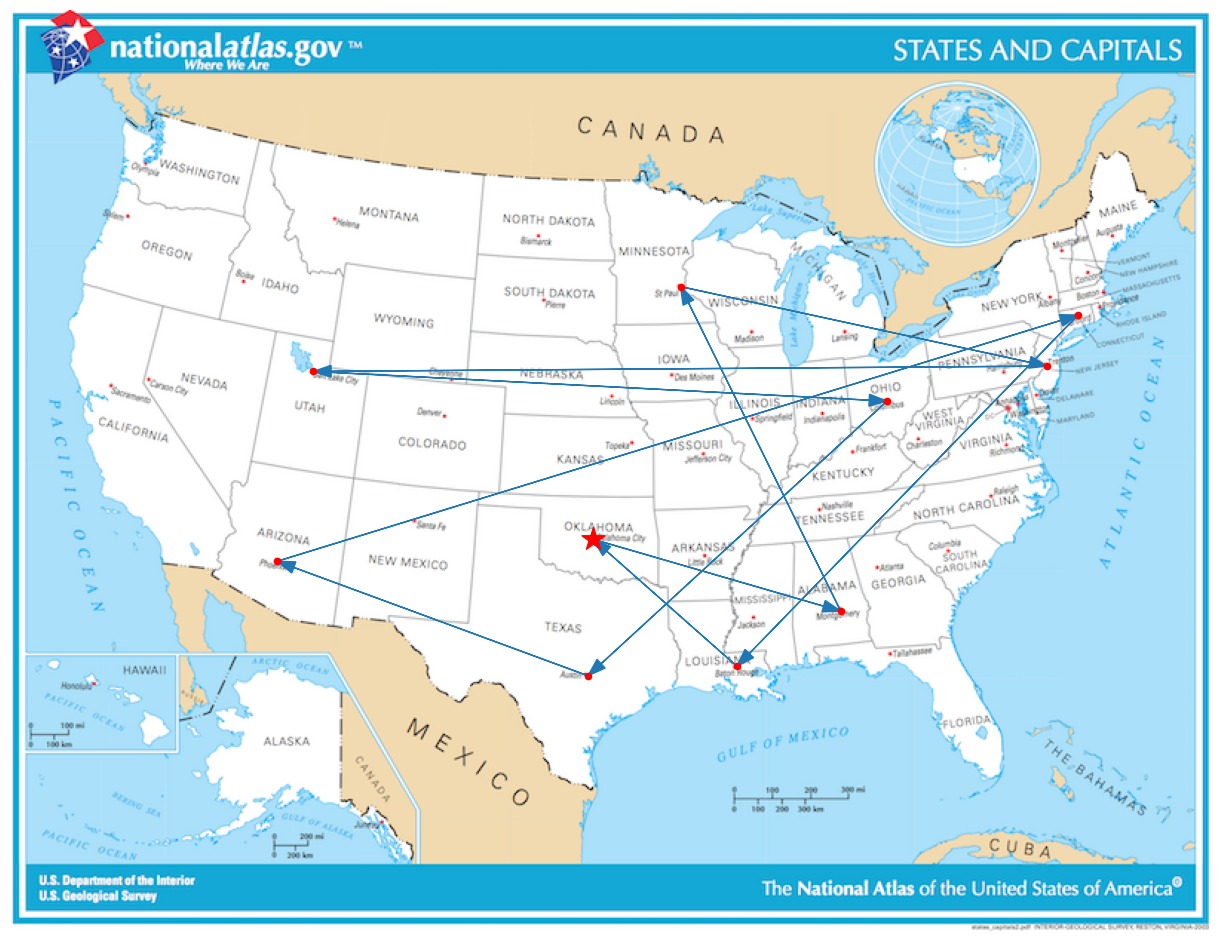

In [82]:
# Create the problem instance and plot the initial state
num_cities = 10
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(capitals_tsp.evaluate()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city, 16, 12)

New path value: 2063.70


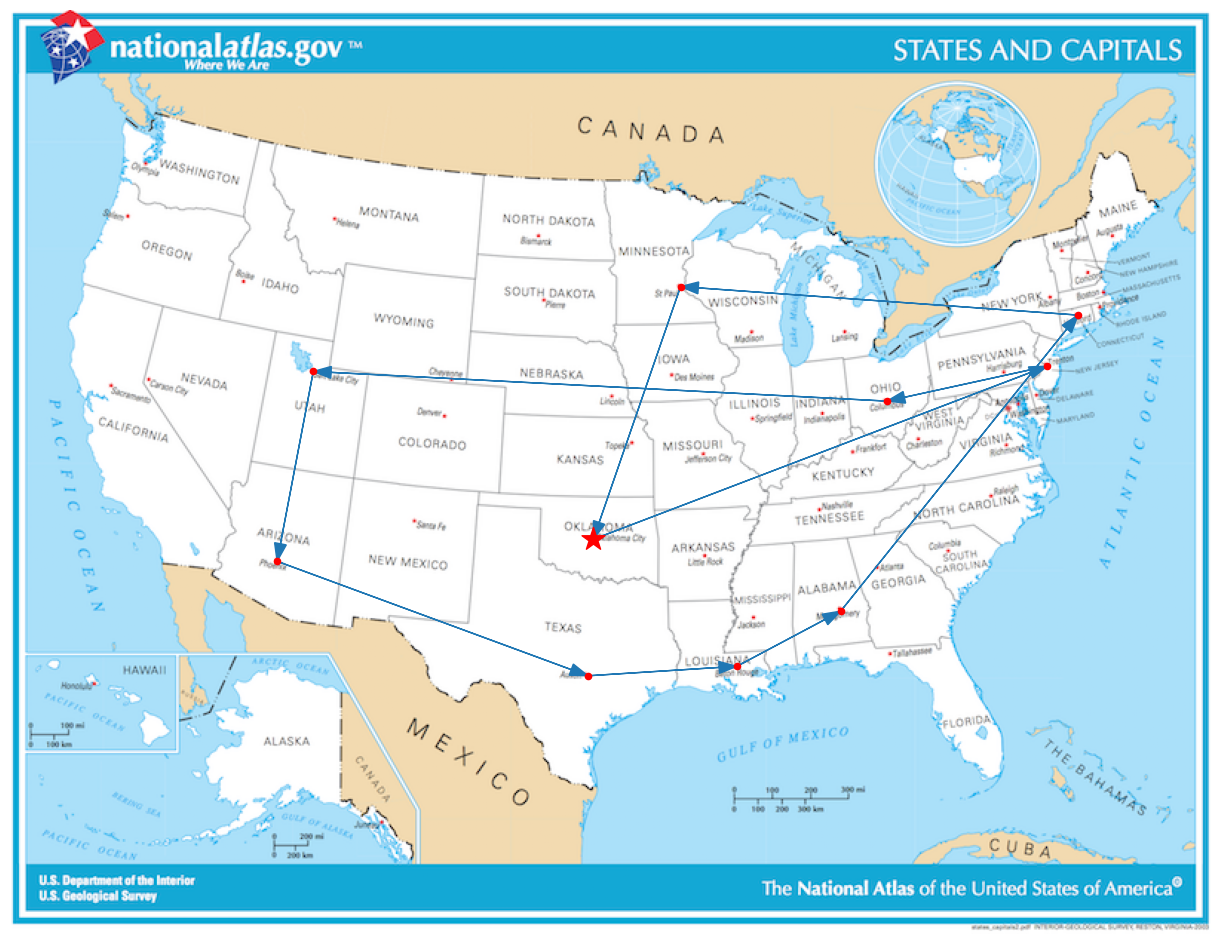

In [83]:
solution = hill_climbing(capitals_tsp)
print("New path value: {:.2f}".format(solution.evaluate()))
show_path(solution.coords, starting_city, 16, 12)